In [1]:
%%bash
echo $CMSSW_BASE
echo $PWD
uname -a
whoami

/afs/cern.ch/work/i/innocent/public/code/s7/CMSSW_9_4_0
/afs/cern.ch/user/i/innocent/pyTools
Linux vinavx3.cern.ch 3.10.0-693.2.2.el7.x86_64 #1 SMP Tue Sep 12 22:26:13 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
innocent


In [2]:
%%bash
edmDumpEventContent root://eoscms.cern.ch///store/data/Run2017F/JetHT/MINIAOD/PromptReco-v1/000/306/091/00000/CA5F7509-04C4-E711-B9B5-02163E011932.root | grep Jet

BXVector<l1t::Jet>                    "caloStage2Digis"           "Jet"             "RECO"    
vector<l1extra::L1JetParticle>        "l1extraParticles"          "Central"         "RECO"    
vector<l1extra::L1JetParticle>        "l1extraParticles"          "Forward"         "RECO"    
vector<l1extra::L1JetParticle>        "l1extraParticles"          "IsoTau"          "RECO"    
vector<l1extra::L1JetParticle>        "l1extraParticles"          "Tau"             "RECO"    
vector<pat::Jet>                      "slimmedJets"               ""                "RECO"    
vector<pat::Jet>                      "slimmedJetsAK8"            ""                "RECO"    
vector<pat::Jet>                      "slimmedJetsPuppi"          ""                "RECO"    
vector<pat::Jet>                      "slimmedJetsAK8PFPuppiSoftDropPacked"   "SubJets"         "RECO"    


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
from multiprocessing import Pool

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
from DataFormats.FWLite import Handle, Events

Welcome to JupyROOT 6.10/09


In [6]:
def files() :
    return [
        'root://eoscms.cern.ch///store/data/Run2017F/JetHT/MINIAOD/PromptReco-v1/000/306/091/00000/CA5F7509-04C4-E711-B9B5-02163E011932.root',
        'root://eoscms.cern.ch///store/relval/CMSSW_9_4_0_pre3/RelValTTbar_13/MINIAODSIM/PU25ns_94X_mc2017_realistic_PixFailScenario_v6_FIXED_HS_AVE50_rsb-v1/10000/1A87EA25-17C1-E711-9ECD-E0071B745DC0.root'
    ]

In [7]:
def runid(event,lumi) :
    id = event.object().id()
    a=event.getByLabel('scalersRawToDigi', lumi)
    return '{:d}:{:d}:{:.2e}'.format(int(id.run()),int(id.luminosityBlock()),\
                                     lumi.product()[0].instantLumi() if not lumi.product().empty() else 0)

In [8]:
def avgHits(jet):
    daus = [ jet.daughter(i) for i in xrange(jet.numberOfDaughters()) ]
    hits = [ d.pixelLayersWithMeasurement() for d in daus if d.charge() != 0 and d.hasTrackDetails() ]
    return (float(sum(hits))/float(len(hits)),len(hits)) if hits else (-99.0,0)                                    

In [9]:
def loadJets(fevents) :
    print fevents
    events = Events(fevents)
    print events.size()
    jets = Handle('vector<pat::Jet>')
    lumi = Handle("std::vector<LumiScalers>")
    evidsA = []
    jtParsA = []
    for i in xrange(0,events.size()) :
      if (len(jtParsA) > 1000000) : break
      a= events.to(i)
      evid = runid(events,lumi)
      if (i%5000==0) : 
        print "Event", i , evid, len(jtParsA)
      a=events.getByLabel("slimmedJets", jets)
      for jt in jets.product() :
        ah,ntk = avgHits(jt)
        if (ah>-1.):
            evidsA.append(evid)
            jtParsA.append([jt.eta(),jt.phi(),jt.pt(),ah,float(ntk)])
        
    print len(jtParsA)
    jtPars = np.array(zip(*jtParsA), dtype=np.float)
    print len(jtPars)
    evids = np.array(evidsA,dtype=np.str)
    return (evids,jtPars)

In [10]:
def process() :
    evids = []
    jtPars = []
    for file in files() :
        e, jt = loadJets(file)
        evids.append(e)
        jtPars.append(jt)

In [17]:
def nhit(var,jtPars) :
    nbins = 62
    hp = np.greater(jtPars[2],15.) & np.greater(jtPars[4],1.1)
    yn,x = np.histogram(jtPars[var],np.linspace(-3.1,3.1,nbins),weights=jtPars[3]*hp)
    ya,x = np.histogram(jtPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp)
    x.resize(len(ya))
    return x,yn/ya,ya

In [18]:
def plots(jtPars) :
    eta=0
    phi=1
    pt=2
    nh=3
    
    hp = np.greater(jtPars[pt],15.) & np.greater(jtPars[4],1.1)
    h3 = np.equal(jtPars[nh],3.)

    ya,x = np.histogram(jtPars[nh],np.linspace(0,6,48),weights=1.*hp)
    x.resize(len(ya))
    plt.step(x,ya,where='post',label='run xyz, lumi??')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim(0, 6)
    plt.xlabel('<NPixLayers>')
    plt.ylabel('Events')
    plt.show()

    ya,x = np.histogram(jtPars[eta],np.linspace(-3.1,3.1,62),weights=1.*h3)
    x.resize(len(ya))
    plt.step(x,ya,where='post',label='run xyz, lumi??')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim(-3.1,3.1)
    plt.xlabel('eta')
    plt.ylabel('Events')
    plt.show()

    x,y,ya = nhit(eta,jtPars)

    plt.step(x,y,where='post',label='run xyz, lumi??')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim(-3.1, 3.1)
    plt.xlabel('eta')
    plt.ylabel('<NPixLayers>')
    plt.show()

    x,y,ya = nhit(phi,jtPars)
    plt.step(x,y,where='post',label='run xyz, lumi??')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim(-3.1, 3.1)
    plt.xlabel('phi')
    plt.ylabel('<NPixLayers>')
    plt.show()

In [19]:
def plots2d(jtPars) :
    nbins = 31
    edges = np.linspace(-3.1,3.1,nbins)
    hp = np.greater(jtPars[2],15.)
    zn,x,y = np.histogram2d(jtPars[0],jtPars[1],bins=(edges, edges),weights=jtPars[3]*hp)
    za,x,y = np.histogram2d(jtPars[0],jtPars[1],bins=(edges, edges),weights=1.*hp)
    z=zn.T/za.T
    #print zn,za
    #    return x,yn/ya,ya
    plt.imshow(z, interpolation='nearest', origin='low', extent=[edges[0], edges[-1], edges[0], edges[-1]])
    plt.colorbar()
    plt.show()

In [20]:
p = Pool(4)
ret = p.map(loadJets,files())
for n in ret : print n[0],len(n[1])

root://eoscms.cern.ch///store/relval/CMSSW_9_4_0_pre3/RelValTTbar_13/MINIAODSIM/PU25ns_94X_mc2017_realistic_PixFailScenario_v6_FIXED_HS_AVE50_rsb-v1/10000/1A87EA25-17C1-E711-9ECD-E0071B745DC0.root
root://eoscms.cern.ch///store/data/Run2017F/JetHT/MINIAOD/PromptReco-v1/000/306/091/00000/CA5F7509-04C4-E711-B9B5-02163E011932.root
24600
51394
Event 0 1:6:0.00e+00 0
Event 0 306091:426:1.52e+04 0
Event 5000 306091:440:1.51e+04 58133
Event 5000 1:121:0.00e+00 56451
Event 10000 306091:450:1.50e+04 115900
Event 10000 1:187:0.00e+00 113238
Event 15000 306091:464:1.49e+04 173266
Event 15000 1:247:0.00e+00 170275
Event 20000 306091:468:9.50e+03 225034
Event 20000 1:350:0.00e+00 227443
Event 25000 306091:509:1.50e+04 283316
Event 30000 306091:524:1.48e+04 340542
280010
5
Event 35000 306091:552:1.45e+04 396771
Event 40000 306091:579:1.42e+04 452705
Event 45000 306091:583:1.42e+04 508300
Event 50000 306091:589:1.42e+04 563372
578649
5
['306091:426:1.52e+04' '306091:426:1.52e+04' '306091:426:1.52e+04'

In [21]:
p.terminate()

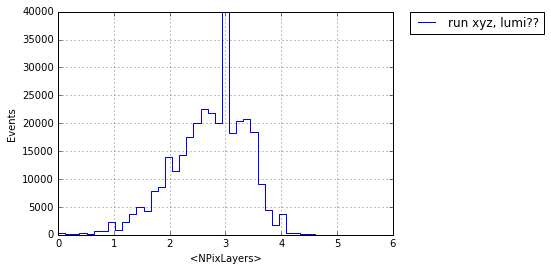

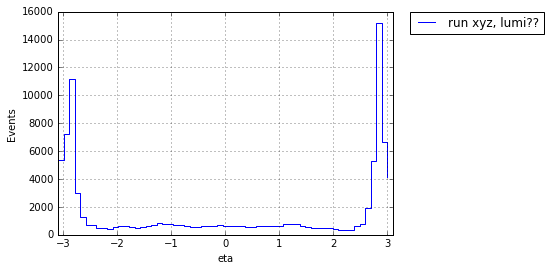

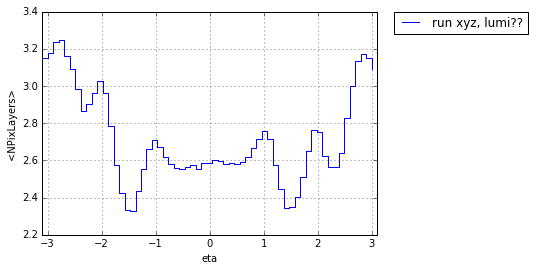

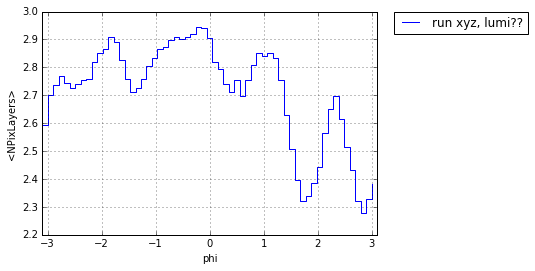

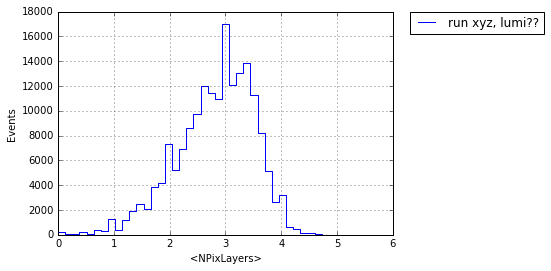

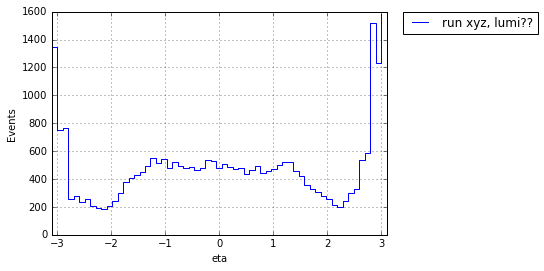

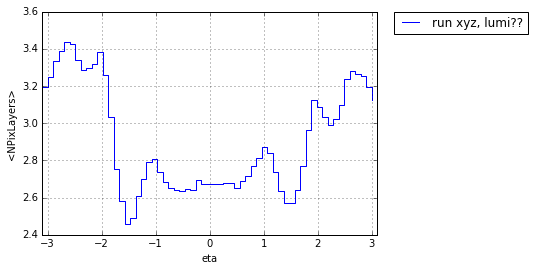

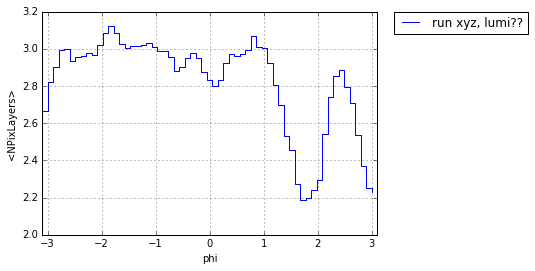

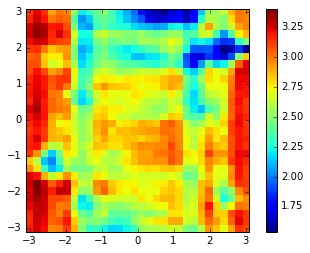

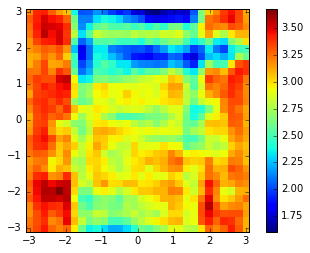

In [22]:
ev,jt = zip(*ret)
for j in jt: 
    plots(j)
for j in jt: 
    plots2d(j)